<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Deep-Learning/blob/master/ResNet_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "nikhileswarkomati"
os.environ['KAGGLE_KEY'] = "001b3a30170775e55950edb6ff0c9b17"
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p /content

100% 3.58G/3.58G [01:05<00:00, 34.2MB/s]
100% 3.58G/3.58G [01:05<00:00, 58.4MB/s]


In [2]:
!unzip \*.zip

Archive:  real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence Dataset/N

In [3]:
!pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12884 sha256=8d99cd83e19623ca8c54833ac2534a4dd0e90ee07823da691ddc4bab8ba5ee3e
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [4]:
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = ['Violence', 'NonViolence']
classes.sort()
# some global params
SIZE = (224,224)
CHANNELS = 3
NBFRAME = 6
BS = 8
# pattern to get videos and classes
glob_pattern = '/content/Real Life Violence Dataset/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    rotation_range=8,
    width_shift_range=.1,
    height_shift_range=.1)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.10, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class NonViolence, validation count: 100, train count: 900
class Violence, validation count: 100, train count: 900
Total data: 2 classes for 1800 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 2 classes for 200 files for validation


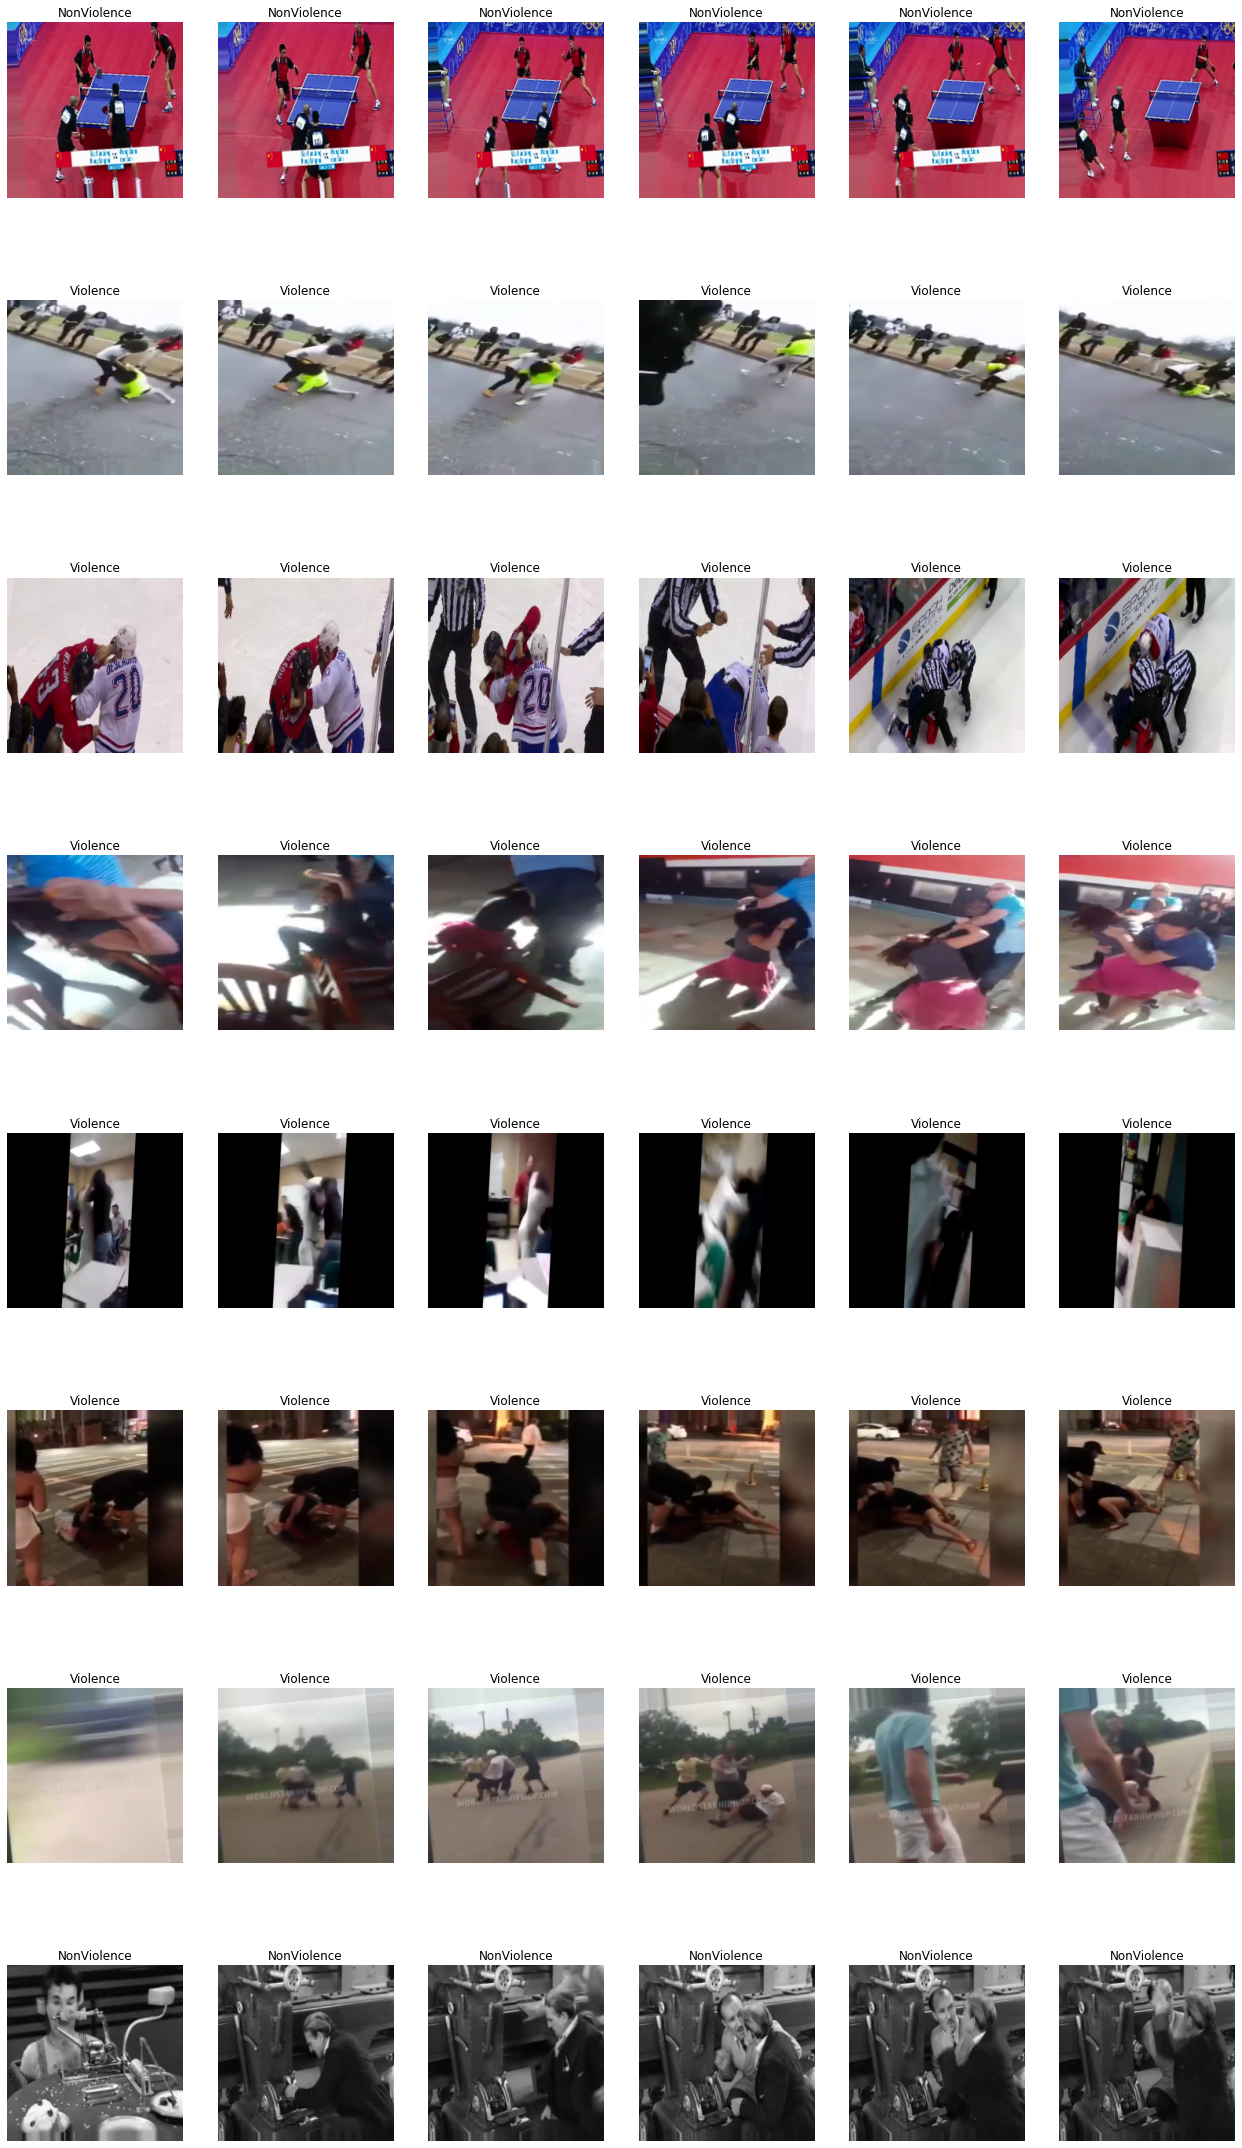

In [6]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [7]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
import keras

In [8]:
def build_res(shape=(224, 224, 3), nbout=2):
    model = keras.applications.InceptionResNetV2(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 152 layers to train﻿﻿
    trainable = 152
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [9]:
def action_model(shape=(6, 224, 224, 3), nbout=2):
    convnet = build_res(shape[1:], nbout = 2)
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape = shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model
    # ...

In [10]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

219062272/219055592 [==============================] - 1s 0us/step


In [11]:
!mkdir chkp
EPOCHS=20
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
history = model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
225/225 [==============================] - 620s 3s/step - loss: 0.7130 - acc: 0.4825 - val_loss: 0.6863 - val_acc: 0.5000

Epoch 00001: saving model to chkp/weights.01-0.69.hdf5
Epoch 2/20
225/225 [==============================] - 155s 687ms/step - loss: 0.6839 - acc: 0.5564 - val_loss: 0.4809 - val_acc: 0.8050

Epoch 00002: saving model to chkp/weights.02-0.48.hdf5
Epoch 3/20
225/225 [==============================] - 155s 686ms/step - loss: 0.4947 - acc: 0.7772 - val_loss: 0.1965 - val_acc: 0.9250

Epoch 00003: saving model to chkp/weights.03-0.20.hdf5
Epoch 4/20
225/225 [==============================] - 155s 688ms/step - loss: 0.2418 - acc: 0.9164 - val_loss: 0.1428 - val_acc: 0.9500

Epoch 00004: saving model to chkp/weights.04-0.14.hdf5
Epoch 5/20
225/225 [==============================] - 155s 689ms/step - loss: 0.2071 - acc: 0.9283 - val_loss: 0.1348 - val_acc: 0.9500

Epoch 00005: saving model to chkp/weights.05-0.13.hdf5
Epoch 6/20
225/225 [=======================

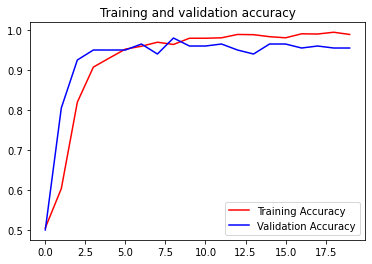

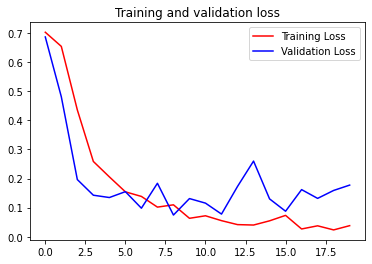

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")


plt.title('Training and validation loss')
plt.legend()
plt.show()